In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from utils.get_sequences import get_sequences
from utils.split_data import split_data
from sklearn.preprocessing import StandardScaler
from data_files.data_module import EnergyChickenDataModule
from model_files.model import LSTM
from model_files.trainer import Trainer
from torch.optim import Adam, SGD, Adadelta, AdamW, Adagrad
import matplotlib.pyplot as plt
import json

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [ ]:
RANDOM_SEED = 42
SPLITER_COUNT = 0.8
WINDOW_LENGHT = 24 * 7 * 4 # window size of one month
BATCH_SIZE = 32
MAX_COUNT_DECREASING = 10
LEARNING_RATE = 0.001
N_EPOCHS = 100
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
df = pd.read_csv('data_files/processed.csv')
df.drop(columns=df.columns[0], inplace=True)
scaler = StandardScaler()
data = torch.FloatTensor(scaler.fit_transform(df.iloc[:, 0].to_numpy().reshape((-1, 1)))).to(DEVICE)
sequences = get_sequences(data, WINDOW_LENGHT)
train, test = split_data(sequences, SPLITER_COUNT)

In [ ]:
optimizers = [Adam, SGD, Adadelta, AdamW] # optimizers that we will test

In [ ]:
comparison_logs = {}

for optimizer in optimizers:
    optimizer_name = str(optimizer).split('.')[-1][:-2]
    print(optimizer_name)

    data_module = EnergyChickenDataModule(train, test)
    data_module.setup()
    model = LSTM(device=DEVICE)
    optimizer = optimizer(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.MSELoss()

    trainer = Trainer(model=model, 
                    optimizer=optimizer, 
                    loss_function=criterion,
                    n_epochs=N_EPOCHS,
                    device=DEVICE,
                    max_count_decreasing=MAX_COUNT_DECREASING)

    train_dataloader = data_module.train_dataloader()
    test_dataloader = data_module.test_dataloader()
    trainer.upload_data(train_dataloader, test_dataloader)

    trainer.fit()
    
    comparison_logs[optimizer_name] = trainer.logs
    with open('comparisons/compatison_results.json', 'w') as file:
        json.dump(comparison_logs, file, ensure_ascii=False, indent=4)
    

Adam


/home/argen7um/Desktop/code/energy_prediction/data_files/dataset.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (torch.Tensor(sequence), torch.tensor(label).float())
/home/argen7um/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch 1 train_loss 0.175279 test_loss 0.196178 time 72.413911
epoch 2 train_loss 0.101826 test_loss 0.179059 time 81.121055
epoch 3 train_loss 0.088578 test_loss 0.154758 time 82.628657
epoch 4 train_loss 0.075007 test_loss 0.129523 time 81.371682
epoch 5 train_loss 0.069915 test_loss 0.109808 time 83.402417
epoch 6 train_loss 0.104125 test_loss 0.129597 time 79.530354
epoch 7 train_loss 0.071208 test_loss 0.085559 time 82.876225
epoch 8 train_loss 0.06392 test_loss 0.062183 time 81.896426
epoch 9 train_loss 0.062765 test_loss 0.075535 time 82.880936
epoch 10 train_loss 0.088271 test_loss 0.120728 time 83.589679
epoch 11 train_loss 0.069655 test_loss 0.108466 time 81.270021
epoch 12 train_loss 0.061306 test_loss 0.072125 time 83.332159
epoch 13 train_loss 0.063976 test_loss 0.060205 time 82.386691
epoch 14 train_loss 0.046833 test_loss 0.04864 time 83.511933
epoch 15 train_loss 0.074475 test_loss 0.120026 time 81.846316
epoch 16 train_loss 0.065033 test_loss 0.045132 time 82.299112
epo

In [6]:
with open('comparisons/compatison_optimizers_14.01.2023.json', 'r') as file:
    comparison_logs = json.load(file)

0.004458  76
0.076972  99
0.159612  99
0.054297  10
0.004685  68
0.105262  99
0.238408  99
0.060872  7


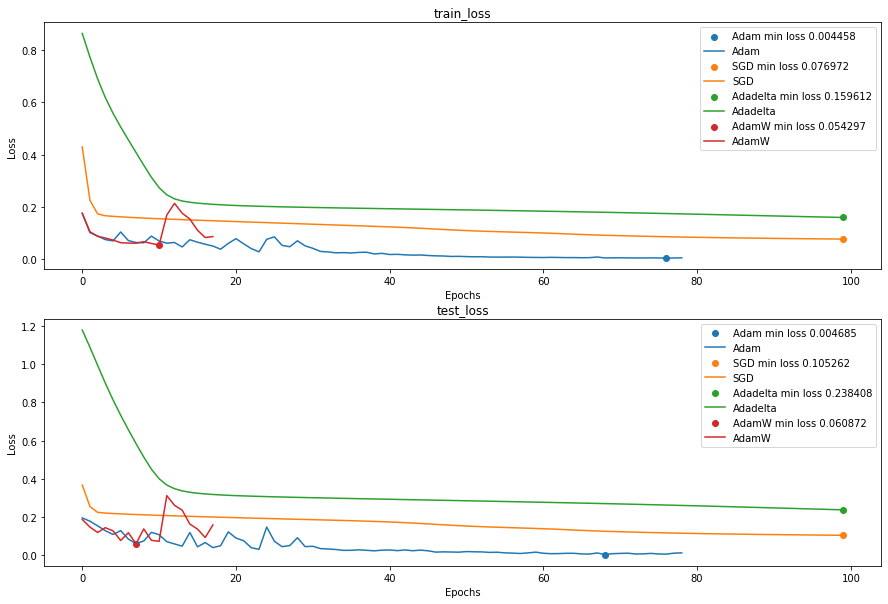

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))

for index, col in enumerate(['train_loss', 'test_loss']):
    for optimizer_name, data in comparison_logs.items():
        loss = data[col]

        min_loss = min(loss)
        min_loss_epoch = loss.index(min_loss)
        ax[index].scatter([min_loss_epoch], [min_loss], label=f'{optimizer_name} min loss {min_loss}')

        ax[index].plot(loss, label=f'{optimizer_name}')
        ax[index].set_title(f'{col}')
        ax[index].set_xlabel('Epochs')
        ax[index].set_ylabel('Loss')
        ax[index].legend()



In [3]:
round((1 - 0.004685 ** 0.5) * 100, 3)

93.155

In [20]:
mean_time = {
    optimizer: float(np.mean(data['time'])) for optimizer, data in comparison_logs.items()
}
mean_time = {k:v for k, v in sorted(mean_time.items(), key=lambda item: item[1])}

<BarContainer object of 4 artists>

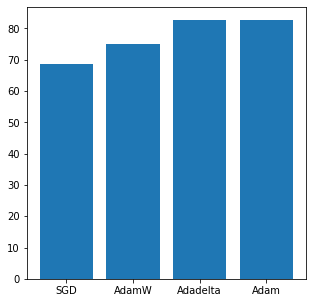

In [25]:
plt.figure(figsize=(5, 5))
plt.bar(mean_time.keys(), mean_time.values())

As you can see, Adam converges faster and learns better than everyone else
